In [1]:
import numpy as np

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tqdm import tqdm
import pickle

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [1]:
class rnn:
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.hi = np.random.randn(self.hidden_nodes, self.input_nodes)*0.1
        self.hh = np.random.randn(self.hidden_nodes, self.hidden_nodes)*0.1
        self.oh = np.random.randn(self.output_nodes, self.hidden_nodes)*0.1
        self.b1 = np.zeros((self.hidden_nodes, ))
        self.b2 = np.zeros((self.output_nodes, ))
    def softmax(self, x):
        x = x.T
        x_max = x.max(axis = 0)
        x -= x_max
        w = np.exp(x)
        w = (w/w.sum(axis = 0)).T
        return w
    def forward(self, X, H_prev):
        h = np.matmul(X, self.hi.T) + np.matmul(H_prev, self.hh.T) + self.b1
        h = np.tanh(h)
        u = np.matmul(h, self.oh.T) + self.b2
        o = self.softmax(u)
        return h, o
    def error(self, Y, O):
        err = -np.mean(np.sum(Y * np.log(O[-1]), axis=1))
        return err
    def backward(self, T, X, Y, O, H):
        N = O.shape[1] 
#         delta = np.zeros((N, self.hidden_nodes)) 

        delta = O[T-1] - Y 
        self.doh = np.matmul(delta.T, H[T-1])/ N #dE/dV
        self.db2 = delta.T.sum(axis = 1)/ N
        delta = np.matmul(delta, self.oh) 
    
        for t in range(T-1, -1, -1):
            delta *= (1 - H[t]**2)
            self.dhh += np.matmul(delta.T, H[t-1])/ N
            self.dhi += np.matmul(delta.T, X[t]) / N
            self.db1 += delta.T.sum(axis = 1)/ N
            delta = np.matmul(delta, self.hh)
    def clip_gradients(self):
        self.doh.clip(-1, 1, out = self.doh)
        self.dhh.clip(-1, 1, out = self.dhh)
        self.dhi.clip(-1, 1, out = self.dhi)
        self.db1.clip(-1, 1, out = self.db1)
        self.db2.clip(-1, 1, out = self.db2)
    def zero_gradients(self):
        self.doh = np.zeros((self.output_nodes, self.hidden_nodes))
        self.dhh = np.zeros((self.hidden_nodes, self.hidden_nodes))
        self.dhi = np.zeros((self.hidden_nodes, self.input_nodes))
        self.db1 = np.zeros((self.hidden_nodes, ))
        self.db2 = np.zeros((self.output_nodes, ))
    def update_parameters(self, alpha):
        self.oh -= (alpha*self.doh)
        self.hh -= (alpha*self.dhh)
        self.hi -= (alpha*self.dhi)
        self.b1 -= (alpha*self.db1)
        self.b2 -= (alpha*self.db2)

In [8]:
T = 28 # time steps
# x_train, y_train, x_test, y_test
N = 60000 # no. of training examples
N_TEST = 10000 # no. of testing examples

INPUT_NODES = 28
OUTPUT_NODES = 10
HIDDEN_NODES = 256

BATCH_SIZE = 60
BATCHES = int(N/BATCH_SIZE)

if __name__ == "__main__":

    X = x_train[:N].reshape(N, T, INPUT_NODES)
    Y = np.zeros((N, OUTPUT_NODES))
#     把 Y 換成 e_i 形式
    for i in range(N):
        temp = np.zeros((OUTPUT_NODES, ))
        temp[y_train[i]] = 1
        Y[i] = temp
    
    model = rnn(INPUT_NODES, HIDDEN_NODES, OUTPUT_NODES)
    

    EPOCHS = 10
    ALPHA = 0.001
    training_loss = []
    
    for epoch in range(EPOCHS):
        # shuffle
        perm = np.random.permutation(len(X))
        X = X[perm]
        Y = Y[perm]
        
        loss = 0.
        pbar = tqdm(range(BATCHES), unit = "batches")
        
        for batch in pbar:
            H = np.zeros((T+1, BATCH_SIZE, model.hidden_nodes))
            O = np.zeros((T, BATCH_SIZE, model.output_nodes))

            X_B = X[batch*BATCH_SIZE:batch*BATCH_SIZE + BATCH_SIZE].transpose(1,0,2)
            Y_B = Y[batch*BATCH_SIZE:batch*BATCH_SIZE + BATCH_SIZE]
            
            for t in range(T):
                H[t], O[t] = model.forward(X_B[t], H[t-1])

            # ensure gradients are initialised to zero
            model.zero_gradients()
        
            # compute gradients
            model.backward(T, X_B, Y_B, O, H)
            
#             model.clip_gradients()
        
            # update parameters
            model.update_parameters(ALPHA)

            curr_batch_loss = model.error(Y_B, O)
            pbar.set_description(f"Epoch: {epoch}, Batch: {batch}, loss: {round(curr_batch_loss, 2)}")
            
            loss += curr_batch_loss/ BATCHES

        print(f"Error after epoch {epoch}: {loss}")
        training_loss.append(loss)
    
    pickle.dump(training_loss, open("training_loss.pkl", "wb"))
    pickle.dump(model, open("model.pkl", "wb"))

Epoch: 0, Batch: 999, loss: 0.52: 100%|██████████| 1000/1000 [00:38<00:00, 26.13batches/s]


Error after epoch 0: 0.9811717059293217


Epoch: 1, Batch: 999, loss: 0.43: 100%|██████████| 1000/1000 [00:28<00:00, 34.81batches/s]


Error after epoch 1: 0.44053154280784235


Epoch: 2, Batch: 999, loss: 0.3: 100%|██████████| 1000/1000 [00:29<00:00, 33.97batches/s]


Error after epoch 2: 0.32664765812441293


Epoch: 3, Batch: 999, loss: 0.15: 100%|██████████| 1000/1000 [00:34<00:00, 29.36batches/s]


Error after epoch 3: 0.27033004892107115


Epoch: 4, Batch: 999, loss: 0.16: 100%|██████████| 1000/1000 [00:30<00:00, 33.27batches/s]


Error after epoch 4: 0.2359748692020709


Epoch: 5, Batch: 999, loss: 0.15: 100%|██████████| 1000/1000 [00:32<00:00, 30.67batches/s]


Error after epoch 5: 0.21201488636130872


Epoch: 6, Batch: 999, loss: 0.49: 100%|██████████| 1000/1000 [00:34<00:00, 28.62batches/s]


Error after epoch 6: 0.19340100974295926


Epoch: 7, Batch: 999, loss: 0.18: 100%|██████████| 1000/1000 [00:36<00:00, 27.73batches/s]


Error after epoch 7: 0.17844937288885557


Epoch: 8, Batch: 999, loss: 0.14: 100%|██████████| 1000/1000 [00:31<00:00, 31.89batches/s]


Error after epoch 8: 0.16609370387364197


Epoch: 9, Batch: 999, loss: 0.21: 100%|██████████| 1000/1000 [00:30<00:00, 33.24batches/s]

Error after epoch 9: 0.15565288852344528


In [13]:
model.dhi[1]

array([ 0.00000000e+00,  0.00000000e+00,  5.87010012e-06,  1.00959024e-05,
        9.02451376e-04,  8.42754212e-04,  2.04191622e-03,  1.99060435e-03,
       -7.02071487e-03, -8.59115566e-03, -1.30464533e-04,  1.37238889e-02,
        2.43020734e-02,  1.61271556e-02,  2.05789181e-02,  3.79745645e-02,
        1.86773256e-02,  2.18379943e-02,  5.67432328e-03,  7.24537619e-03,
        3.75161977e-03,  3.77335493e-03,  2.20025986e-03,  6.33991679e-04,
       -5.01795096e-04,  4.03885310e-04,  0.00000000e+00,  0.00000000e+00])

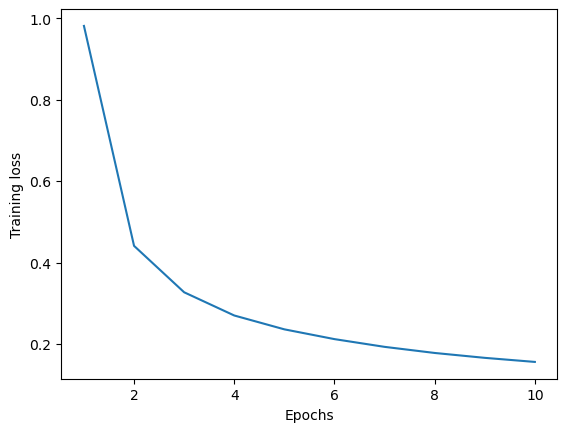

In [9]:
training_loss = pickle.load(open("training_loss.pkl", "rb"))
training_loss = [round(x, 3) for x in training_loss]
epochs = np.arange(0, EPOCHS) + 1
plt.plot(epochs, training_loss, label = "training loss")
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.savefig('plot.png')
plt.show()

In [10]:
model = pickle.load(open("model.pkl", "rb"))

X_TEST = x_test[:N_TEST].reshape(N_TEST, T, INPUT_NODES)
X_TEST = X_TEST.transpose(1, 0, 2)
Y_TEST = y_test[:N_TEST].T

H_TEST = np.zeros((T+1, N_TEST, model.hidden_nodes))
O_TEST = np.zeros((T, N_TEST, model.output_nodes))

for t in tqdm(range(T), desc = f"Running forward pass.."):
    H_TEST[t], O_TEST[t] = model.forward(X_TEST[t], H_TEST[t-1])

correct_ans = (np.argmax(O_TEST[-1], axis = 1) == Y_TEST).sum()
accuracy = (correct_ans/ N_TEST) * 100
print(f"Test Accuracy: {accuracy}")

Running forward pass..: 100%|██████████| 28/28 [00:01<00:00, 15.19it/s]

Test Accuracy: 94.58
